# Calculate travel time, azimuth, and takeoff angle based on Eikonal equation

In [28]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

## Solve Eikonal equation

In [29]:
############################################################################################################
# |\nabla u| = f

# ((u - a1)^+)^2 + ((u - a2)^+)^2 + ((u - a3)^+)^2 = f^2 h^2


def calculate_unique_solution(a, b, f, h):

    d = abs(a - b)
    if d >= f * h:
        return min(a, b) + f * h
    else:
        return (a + b + np.sqrt(2 * f * f * h * h - (a - b) ** 2)) / 2


def sweeping_over_I_J_K(u, I, J, f, h):

    m = len(I)
    n = len(J)
    
    for (i,j) in itertools.product(I, J):
        if i == 0:
            uxmin = u[i + 1, j]
        elif i == m - 1:
            uxmin = u[i - 1, j]
        else:
            uxmin = np.min([u[i - 1, j], u[i + 1, j]])

        if j == 0:
            uymin = u[i, j + 1]
        elif j == n - 1:
            uymin = u[i, j - 1]
        else:
            uymin = np.min([u[i, j - 1], u[i, j + 1]])

        u_new = calculate_unique_solution(uxmin, uymin, f[i, j], h)

        u[i, j] = np.min([u_new, u[i, j]])

    return u


def sweeping(u, v, h):

    f = 1.0 / v  ## slowness

    m, n = u.shape
    I = list(range(m))
    iI = I[::-1]
    J = list(range(n))
    iJ = J[::-1]

    u = sweeping_over_I_J_K(u, I, J, f, h)
    u = sweeping_over_I_J_K(u, iI, J, f, h)
    u = sweeping_over_I_J_K(u, iI, iJ, f, h)
    u = sweeping_over_I_J_K(u, I, iJ, f, h)

    return u


def eikonal_solve(u, f, h):

    for i in range(50):
        u_old = np.copy(u)
        u = sweeping(u, f, h)

        err = np.max(np.abs(u - u_old))
        print(f"Iteration {i}, Error = {err}")
        if err < 1e-6:
            break

    return u

############################################################################################################

def normalize(vars_, bounds):
    mean = torch.tensor(
        [
            [
                (bounds[0][0] + bounds[0][1]) / 2,
                (bounds[1][0] + bounds[1][1]) / 2,
                (bounds[2][0] + bounds[2][1]) / 2,
            ],
        ],
        dtype=torch.float32,
    )
    std = torch.tensor(
        [
            [
                (bounds[0][1] - bounds[0][0]) / 2,
                (bounds[1][1] - bounds[1][0]) / 2,
                (bounds[2][1] - bounds[2][0]) / 2,
            ]
        ],
        dtype=torch.float32,
    )
    vars = (vars_ - mean) / std
    vars = torch.tanh(vars)
    vars = (vars * std) + mean

    return vars

Iteration 0, Error = 999.95
Iteration 1, Error = 0.0
Iteration 0, Error = 999.9125
Iteration 1, Error = 0.0


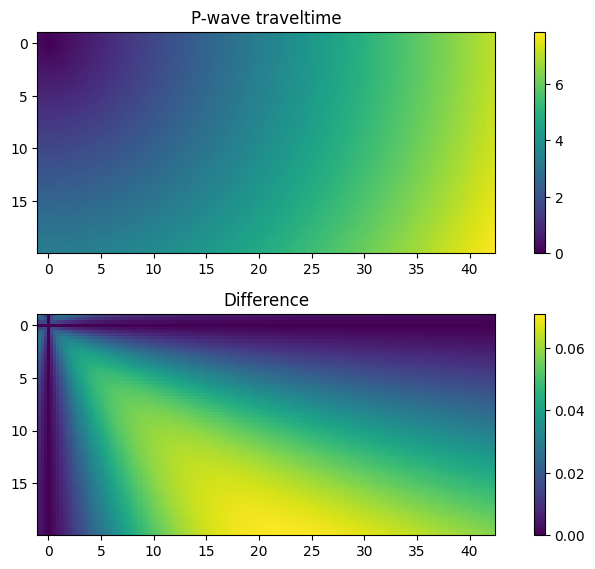

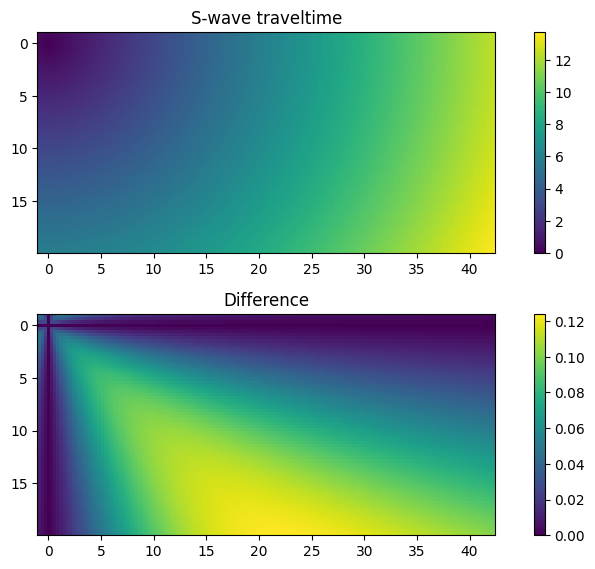

In [30]:
xlim = [0, 30]
ylim = [0, 30]
zlim = [0, 20]  ## depth
h = 0.3
edge_grids = 3

rlim = [0, ((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2) ** 0.5]

rx = np.arange(rlim[0]-edge_grids*h, rlim[1], h)
zx = np.arange(zlim[0]-edge_grids*h, zlim[1], h)
m = len(rx)
n = len(zx)

vp = np.ones((m, n)) * 6.0
vs = np.ones((m, n)) * (6.0 / 1.75)

up = 1000 * np.ones((m, n))
up[edge_grids, edge_grids] = 0.0
up = eikonal_solve(up, vp, h)

us = 1000 * np.ones((m, n))
us[edge_grids, edge_grids] = 0.0
us = eikonal_solve(us, vs, h)

############################## Check eikonal ##################################
rgrid, zgrid = np.meshgrid(rx, zx, indexing="ij")
up_true = np.sqrt((rgrid - 0) ** 2 + (zgrid - 0) ** 2) / np.mean(vp)
us_true = np.sqrt((rgrid - 0) ** 2 + (zgrid - 0) ** 2) / np.mean(vs)

fig, axes = plt.subplots(2, 1, squeeze=False, figsize=(8, 6 * n / m * 2))
im0 = axes[0,0].pcolormesh(rx, zx, up.T)
axes[0,0].axis("scaled")
axes[0,0].invert_yaxis()
axes[0,0].set_title("P-wave traveltime")
fig.colorbar(im0, ax=axes[0,0])

im1 = axes[1,0].pcolormesh(rx, zx, (up - up_true).T)
axes[1,0].axis("scaled")
axes[1,0].invert_yaxis()
axes[1,0].set_title("Difference")
fig.colorbar(im1, ax=axes[1,0])
plt.tight_layout()
fig.savefig("test_vp.png")

fig, axes = plt.subplots(2, 1, squeeze=False, figsize=(8, 6 * n / m * 2))
im0 = axes[0,0].pcolormesh(rx, zx, us.T)
axes[0,0].axis("scaled")
axes[0,0].invert_yaxis()
axes[0,0].set_title("S-wave traveltime")
fig.colorbar(im0, ax=axes[0,0])

im1 = axes[1,0].pcolormesh(rx, zx, (us - us_true).T)
axes[1,0].axis("scaled")
axes[1,0].invert_yaxis()
axes[1,0].set_title("Difference")
fig.colorbar(im1, ax=axes[1,0])
plt.tight_layout()
fig.savefig("test_vs.png")

## Extract event travel time

In [31]:
def traveltime(event_loc, station_locs, time_table, dx, rgrid, zgrid, sigma=1, bounds=None):

    if bounds is not None:
        vars = normalize(event_loc, bounds)
    else:
        vars = event_loc

    r = torch.sqrt(torch.sum((event_loc[0, :2] - station_locs[:, :2]) ** 2, dim=-1))
    z = torch.abs(event_loc[0, 2] - station_locs[:, 2])

    r = r.unsqueeze(-1).unsqueeze(-1)
    z = z.unsqueeze(-1).unsqueeze(-1)

    magn = (
        1.0
        / (2.0 * np.pi * sigma)
        * torch.exp(-(((rgrid - r) / (np.sqrt(2 * sigma) * dx)) ** 2 + ((zgrid - z) / (np.sqrt(2 * sigma) * dx)) ** 2))
    )
    sum_magn = torch.sum(magn, dim=(-1, -2))
    tt = torch.sum(time_table * magn, dim=(-1, -2)) / sum_magn

    return tt

In [32]:
rx = torch.from_numpy(rx)
zx = torch.from_numpy(zx)
up = torch.from_numpy(up)
us = torch.from_numpy(us)

In [33]:
sigma = 0.8
event_locs = torch.tensor([[30, 40, 20]], requires_grad=True, dtype=torch.float32)  # (1, 3)
station_locs = torch.tensor([[20, 20, 0]])  # (nsta, 3)
r = torch.sqrt(torch.sum((event_locs[0, :2] - station_locs[:, :2]) ** 2, axis=-1))  # (nsta, 3)
z = torch.abs(event_locs[0, 2] - station_locs[:, 2])  # (nsta, 1)

r = r.unsqueeze(-1).unsqueeze(-1)
z = z.unsqueeze(-1).unsqueeze(-1)
rgrid, zgrid = torch.meshgrid(rx, zx, indexing="ij")

tp = traveltime(event_locs, station_locs, up, h, rgrid, zgrid, sigma=sigma)
ts = traveltime(event_locs, station_locs, us, h, rgrid, zgrid, sigma=sigma)

tp_true = (r[:, 0, 0] ** 2 + z[:, 0, 0] ** 2) ** 0.5 / np.mean(vp)
ts_true = (r[:, 0, 0] ** 2 + z[:, 0, 0] ** 2) ** 0.5 / np.mean(vs)

print(f"tp = {tp}, tp_true = {tp_true}")
print(f"ts = {ts}, ts_true = {ts_true}")

tp = tensor([5.0416], dtype=torch.float64, grad_fn=<DivBackward0>), tp_true = tensor([5.], grad_fn=<DivBackward0>)
ts = tensor([8.8229], dtype=torch.float64, grad_fn=<DivBackward0>), ts_true = tensor([8.7500], grad_fn=<DivBackward0>)


## Calculate azimuth and takeoff angle

In [34]:
external_grad = torch.tensor([1., ])
tp.backward(gradient=external_grad)


In [35]:
event_grad = event_locs.grad
azimuth = torch.atan2(event_grad[0, 1], event_grad[0, 0])
takeoff_angle = torch.atan2(torch.sqrt(event_grad[0, 0] ** 2 + event_grad[0, 1] ** 2), event_grad[0, 2])


In [36]:
print(f"azimuth = {torch.rad2deg(azimuth):.2f}, takeoff angle = {torch.rad2deg(takeoff_angle):.2f}")

azimuth = 63.43, takeoff angle = 77.90
